In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import colors
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 4, 'ytick.major.width': 1, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
atf2_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/ATF2/direct_loss.bed"
lef1_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/LEF1/direct_loss.bed"

In [4]:
def read_tf_df(filename, libn):
    colnames = ["chrom", "start", "end", "chrom_coord", f"{libn}_act", "strand", f"{libn}_log2FoldChange_act", f"gene_name", f"{libn}_log2FoldChange_exp", f"{libn}_padj_act", f"{libn}_padj_exp", "CC_peak", f"{libn}_peak"]
    return pd.read_csv(filename, sep="\t", header=None, names=colnames)

In [5]:
atf2_df = read_tf_df(atf2_file, "ATF2")
lef1_df = read_tf_df(lef1_file, "LEF1")

In [6]:
merged_df = atf2_df.merge(lef1_df, on=["chrom", "start", "end", "chrom_coord", "gene_name", "strand", "CC_peak"])

In [7]:
act_plot_df = merged_df.loc[:, ["chrom_coord", "ATF2_log2FoldChange_act", "LEF1_log2FoldChange_act"]].set_index("chrom_coord")

In [8]:
libs=["ATF2", "LEF1"]

plot_df = merged_df.set_index("chrom_coord").loc[:, [f"{lib}_log2FoldChange_{t}" for lib in libs for t in ["act", "exp"]]]
annot_df = merged_df.set_index("chrom_coord").loc[:, [f"{lib}_padj_{t}" for lib in libs for t in ["act", "exp"]]].applymap(lambda x: -np.log10(x))


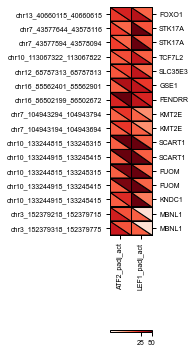

In [9]:
fig, ax = plt.subplots(figsize=(0.75, 7))

M = len(annot_df.columns)//2
N = len(annot_df)
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)
act = annot_df.loc[:, [c for c in annot_df.columns if "_act" in c]].values
act = act.ravel() # [:-1, :-1]
exp = annot_df.loc[:, [c for c in annot_df.columns if "_exp" in c]].values
exp = exp.ravel() # [:-1, :-1]

divnorm_act=colors.TwoSlopeNorm(vmin=1.3, vcenter=3, vmax=50)
divnorm_exp=colors.TwoSlopeNorm(vmin=1.3, vcenter=3, vmax=50)


triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
img1 = plt.tripcolor(triang1, act, cmap=plt.get_cmap('Reds'), norm=divnorm_act, edgecolors="k", linewidths=1.05)
img2 = plt.tripcolor(triang2, exp, cmap=plt.get_cmap('Reds'), norm=divnorm_exp, edgecolors="k", linewidths=1.05)


# ax2.set_yticklabels(annot_df["gene_name"].values) 
# ax2.tick_params(axis="y", right=True, labelright=True)
# 
plt.colorbar(img1, pad=0.25, location="bottom", orientation="horizontal", ax=ax)
ax.set_xlim(x[0], x[-1])
ax.set_ylim(y[0], y[-1])
ax.set_xticks(x[:-1]+0.5, [c.replace("_log2FoldChange_act", "") for c in annot_df.columns if "_act" in c], rotation=90)
ax.set_yticks(y[:-1]+0.5, annot_df.index)

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y[:-1]+0.5, merged_df.gene_name)

plt.show()


In [10]:
save_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/figures/atf2_lef1_common.pdf"
save_pdf(save_file, fig)
